In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json

import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import config

In [4]:
# PRE CONFIGURATION

scopes = ["https://www.googleapis.com/auth/youtube",
          "https://www.googleapis.com/auth/youtube.force-ssl",
          "https://www.googleapis.com/auth/youtube.readonly",
          "https://www.googleapis.com/auth/youtubepartner",
          "https://www.googleapis.com/auth/youtubepartner-channel-audit"]

# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=config.api_key)

In [ ]:
# TEST REQUEST
request = youtube.channels().list(
    part="snippet, contentDetails, statistics",
    id="UCMMLLXn8fVsYxuPRyNv1vVQ"
)
response = request.execute()

#print(response)
#print(json.dumps(response, indent=2, ensure_ascii=False, sort_keys=True))

In [6]:
def get_channel_stats(youtube, channel_ids):
    
    data_stats = []

    # if it's a list, we convert it to a string
    if type(channel_ids) == list: 
        channel_ids = ','.join(channel_ids)

    # make the request
    request = youtube.channels().list(
        part="snippet, contentDetails, statistics",
        id=channel_ids # make a string for all channels (originally is a list)
        )
    response = request.execute()

    # iterate each feature info from channel
    for item in response['items']:
        data_stat = {'channel_name': item['snippet']['title']
                    , 'subscribers': item['statistics']['subscriberCount']
                    , 'views': item['statistics']['viewCount']
                    , 'videos': item['statistics']['videoCount']
                    , 'url': 'youtube.com/' + item['snippet']['customUrl']
                    , 'playlist_id': item['contentDetails']['relatedPlaylists']['uploads'] 
                    , 'created_at': item['snippet']['publishedAt']
                    }
        data_stats.append(data_stat)
    
    return data_stats

In [7]:
def get_video_ids(youtube, playlist_id):
    
    # create a list to save info
    video_ids = []

    # make the request
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        maxResults=50,
        playlistId=playlist_id
        )
    response = request.execute()

    # get the video id, we only can get 50 video id's per page
    for video in response['items']:
        video_ids.append(video['contentDetails']['videoId'])
    
    # get the next page (token)
    next_page_token = response.get('nextPageToken')

    # repeat the process until there are not more pages
    while next_page_token is not None:

        # make the request with the new token
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            maxResults=50,
            playlistId=playlist_id,
            pageToken=next_page_token
            )
        response = request.execute()

        # get the video id
        for video in response['items']:
            video_ids.append(video['contentDetails']['videoId'])
    
        # get the next page
        next_page_token = response.get('nextPageToken')

    # limit the videos to 150 for dont pass the max quota for youtube API
    video_ids = video_ids[0:150]
    
    return video_ids

In [8]:
def get_video_info(youtube, video_ids):

    # principal variable for all videos
    total_videos_info = []

    # iterate each 50 videos from the list of videos (since 50 it's the limit for Youtube API)
    for i in range(0,len(video_ids),50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics, topicDetails, player",
            id=','.join(video_ids[i:i+50]), 
        )
        response = request.execute()

        # iterate each video to get info
        for video in response['items']:
            # another way to extract info from JSON )when we need to extract many features)
            video_json_format = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption']
            }

            # define the variable that save the info for 1 video
            video_info = {}
            # get the video id in the variable
            video_info['video_id'] = video['id']  

            # for each key (snippet, statistics, contentDetails)
            for key in video_json_format.keys():
                # for each value (channelTitle, viewCount, duration, ...)
                for value in video_json_format[key]:
                    # save the value info in the variable
                    try:
                        video_info[value] = video[key][value]

                    except:
                        video_info[value] = None

            # append to the principal variable of all videos
            total_videos_info.append(video_info)

    return total_videos_info

In [9]:
def get_comments_info(youtube, video_ids):

    all_comments = []

    # for each video
    for video_id in video_ids:

        try:
            request = youtube.commentThreads().list(
                part="snippet, replies",
                videoId=video_id
            )
            response = request.execute()
        
            # for each comment of video
            for item in response['items'][0:10]:
                comment_info = {'comment': item['snippet']['topLevelComment']['snippet']['textDisplay']
                                , 'replies': item['snippet']['totalReplyCount']
                                , 'video_id': video_id}

                all_comments.append(comment_info)

        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)

    return all_comments

MAIN CODE

In [10]:
channel_ids = ['UCsbq2Z-NUpT2xFV7o8HXEnA' # la pildora magica
                , 'UCRlBDnRQduDk4tmm1OtpSRg' # un poco mejor
                , 'UCu1C0mYQjWPFNmmMXJ40X7A' # jorge benito
                , 'UCUQfpwJdQJBunbMukf_xdHQ' # arata academy
                , 'UC5gRVpn41gx7b56gMt5Rv5A' # algo de bueno
                , 'UCI--6fK5nJdFXN-jXBmA9Tw' # aprendiz financiero
                , 'UCJoOIj9Yu71wklP3EFzL8-A' # sadhguru
                ]

df_video = pd.DataFrame()
df_comments = pd.DataFrame()

# iterate channels
for channel_id in channel_ids:

    # get channel stats
    df_stats_channel = get_channel_stats(youtube, channel_id)

    # we add [0] because the var df_stats_channel is a list
    print(f"Getting information from channel: {df_stats_channel[0]['channel_name']}")

    # get all video ids from channel
    video_ids = get_video_ids(youtube, df_stats_channel[0]['playlist_id'])

    # get data from videos
    videos_data = get_video_info(youtube, video_ids)

    # get data from comments
    comments_data = get_comments_info(youtube, video_ids)

    # append videos and comments data to dataframes
    df_video = pd.concat([pd.DataFrame(videos_data), df_video])
    df_comments = pd.concat([pd.DataFrame(comments_data), df_comments])

    print(f"Finished!")

    

Getting information from channel: La Píldora Mágica
Finished!
Getting information from channel: Un Poco Mejor
Finished!
Getting information from channel: Jorge Benito
Finished!
Getting information from channel: Arata Academy SPANISH
Could not get comments for video KSM_TgmhMiQ
Could not get comments for video -PIp6qP3qHk
Could not get comments for video qHnjtxKK4Bs
Could not get comments for video KV0ue35J2ss
Could not get comments for video 4t0UHagRixk
Could not get comments for video d4zR7J6zOV0
Could not get comments for video B5douLGfc3w
Could not get comments for video aP9bOQsTGK4
Could not get comments for video RC1Q2c6Qgxs
Finished!
Getting information from channel: Algo de Bueno
Finished!
Getting information from channel: Aprendiz Libros
Finished!
Getting information from channel: Sadhguru Español
Finished!


## Feature engineering

Checking data

In [11]:
df_video.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [12]:
df_video.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [13]:
df_video.publishedAt.sort_values().value_counts()

2022-07-23T15:00:24Z    2
2018-06-20T20:24:49Z    1
2022-08-03T00:16:21Z    1
2022-08-06T15:00:08Z    1
2022-08-06T15:00:10Z    1
                       ..
2021-05-02T15:00:17Z    1
2021-05-03T11:34:46Z    1
2021-05-05T15:00:33Z    1
2021-05-06T15:15:46Z    1
2023-01-11T21:30:01Z    1
Name: publishedAt, Length: 753, dtype: int64

In [14]:
df_video.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,1asHjCevcSg,Sadhguru Español,¿Cómo arreglar mi ego?,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-11T21:30:01Z,5396,1109,None,15,PT52S,hd,false
1,oItcWfm7cII,Sadhguru Español,¿Son los sueños y la vida solo una ilusión? | ...,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-10T23:00:33Z,17524,1350,None,59,PT5M13S,hd,false
2,ZJuhLdwQHJ4,Sadhguru Español,Cómo crear un mundo maravilloso,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-10T21:30:02Z,21704,2628,None,22,PT50S,hd,false
3,VWy5sRJf2wY,Sadhguru Español,La verdadera razón por la que no termina la gu...,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-09T21:30:04Z,19521,2016,None,37,PT55S,hd,false
4,aINYCki3Ooo,Sadhguru Español,3 maneras de eliminar energías negativas de tu...,Sadhguru da tres consejos sencillos pero efica...,"[sadhguru, sadguru, sadhguru español, energia,...",2023-01-09T03:41:50Z,42323,2950,None,62,PT8M37S,hd,false


Transform and enrich data

In [15]:
# transform to numeric columns
numeric_cols = ['viewCount', 'likeCount', 'commentCount', 'favouriteCount']
df_video[numeric_cols] = df_video[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)


# publish day in the week
from dateutil import parser
df_video['publishedAt_timestamp'] = df_video['publishedAt'].apply(lambda x: parser.parse(x)) 
df_video['publishDayName'] = df_video['publishedAt_timestamp'].apply(lambda x: x.strftime("%A"))

# get seconds
import isodate
df_video['durationSecs'] = df_video['duration'].apply(lambda x: isodate.parse_duration(x))
df_video['durationSecs'] = df_video['durationSecs'].astype('timedelta64[s]')

# Add number of tags
df_video['tagsCount'] = df_video['tags'].apply(lambda x: 0 if x is None else len(x))

# Comments and likes per 1000 view ratio
df_video['likeRatio'] = df_video['likeCount']/ df_video['viewCount'] * 1000
df_video['commentRatio'] = df_video['commentCount']/ df_video['viewCount'] * 1000

# Title character length
df_video['titleLength'] = df_video['title'].apply(lambda x: len(x))

# Add extra column
df_video['channel_video'] = df_video['channelTitle'] + ' - ' + df_video['title']

In [16]:
df_video.head(2)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,...,definition,caption,publishedAt_timestamp,publishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength,channel_video
0,1asHjCevcSg,Sadhguru Español,¿Cómo arreglar mi ego?,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-11T21:30:01Z,5396.0,1109.0,NaN,15.0,...,hd,false,2023-01-11 21:30:01+00:00,Wednesday,52.0,3,205.522609,2.779837,22,Sadhguru Español - ¿Cómo arreglar mi ego?
1,oItcWfm7cII,Sadhguru Español,¿Son los sueños y la vida solo una ilusión? | ...,"Sadhguru Yogui, místico y visionario, es un ma...","[sadhguru, sadguru, sadhguru español]",2023-01-10T23:00:33Z,17524.0,1350.0,NaN,59.0,...,hd,false,2023-01-10 23:00:33+00:00,Tuesday,313.0,3,77.037206,3.366811,62,Sadhguru Español - ¿Son los sueños y la vida s...


## EDA (Exploratory Data Analysis)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams

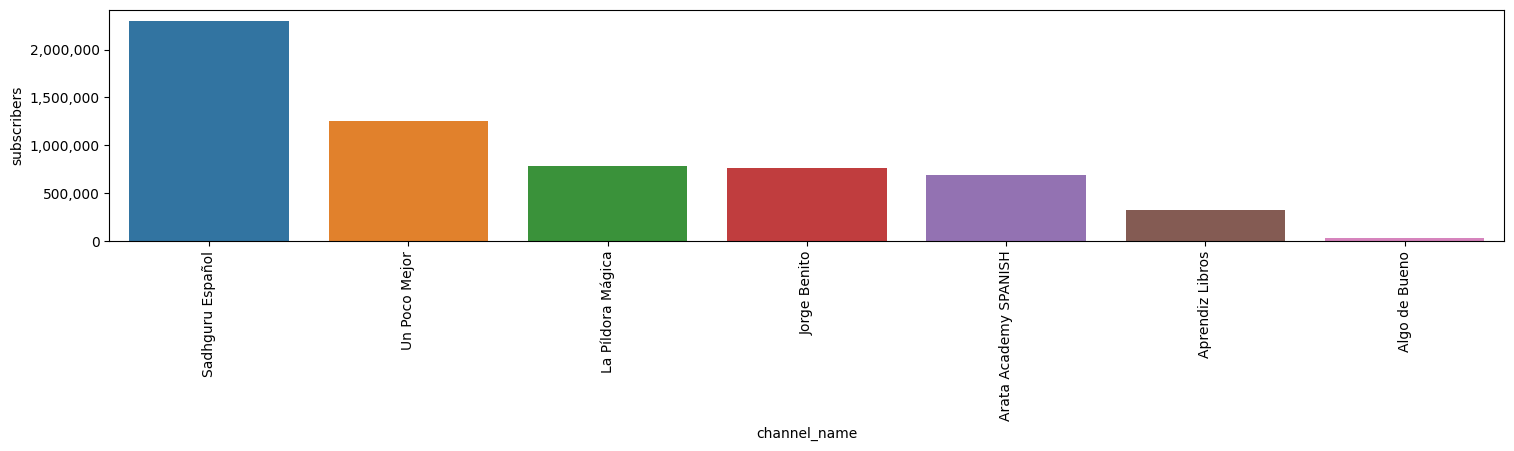

In [18]:
channel_stats = pd.DataFrame(get_channel_stats(youtube, channel_ids))
channel_stats
numeric_cols = ['subscribers','views', 'videos']
channel_stats[numeric_cols] = channel_stats[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

channel_stats['created_at_timestamp'] = channel_stats['created_at'].apply(lambda x: parser.parse(x)) 

ax = sns.barplot(x='channel_name', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



<AxesSubplot:xlabel='created_at_timestamp', ylabel='channel_name'>

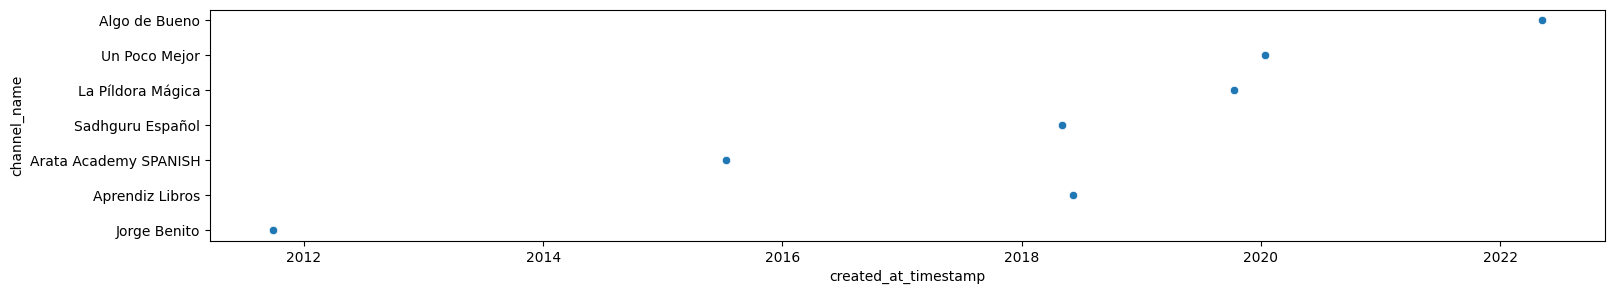

In [19]:
fig, ax =plt.subplots(1,1)
sns.scatterplot(data = channel_stats, x = "created_at_timestamp", y = "channel_name")

#df_video.groupby('channelTitle')['publishedAt_timestamp'].min().rename_axis('channelTitle').reset_index(name='date_first_video')

/home/alejmrv/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


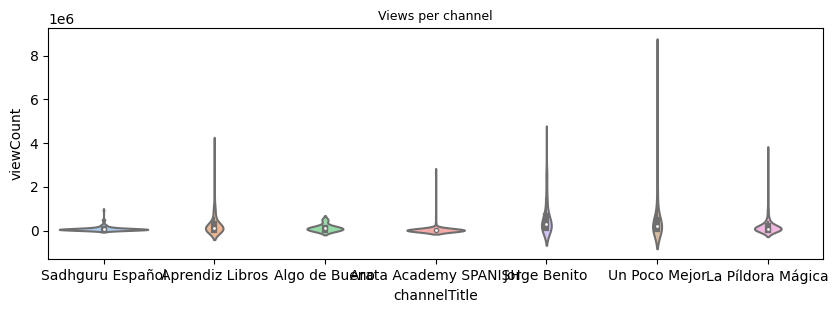

In [20]:
plt.rcParams['figure.figsize'] = (10, 3)
sns.violinplot(df_video['channelTitle'], df_video['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 9)
plt.show()

/home/alejmrv/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


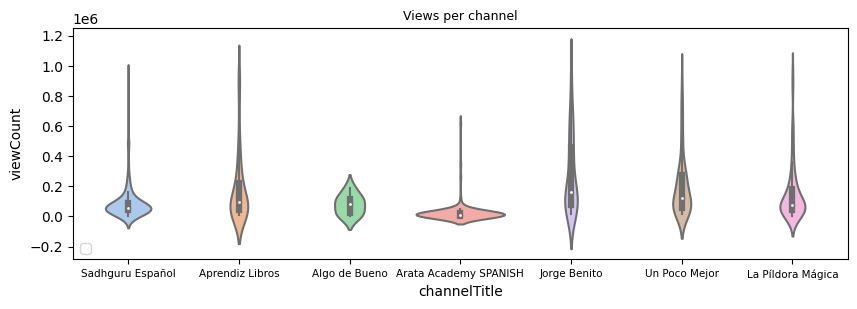

/home/alejmrv/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


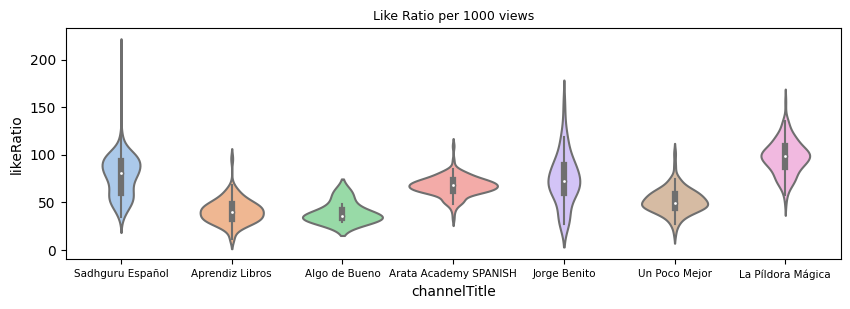

/home/alejmrv/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


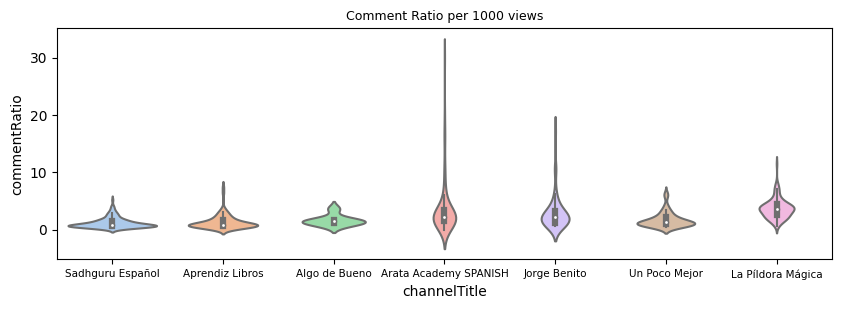

/home/alejmrv/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


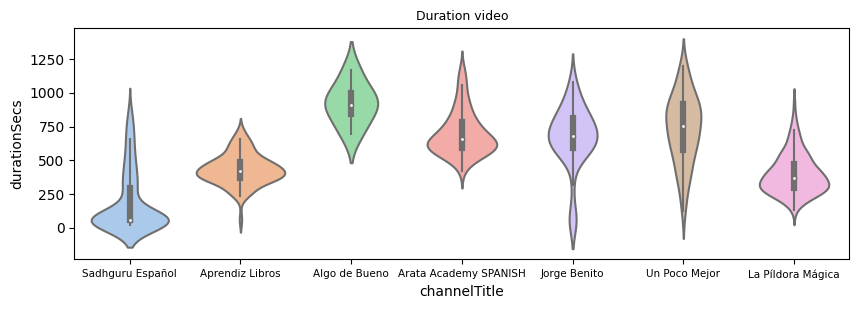

In [21]:
df_video_plot = df_video[(df_video['viewCount']<=1000000) & (df_video['durationSecs']<= 1200)]

plt.rcParams['figure.figsize'] = (10, 3)


fig, ax = plt.subplots()
sns.violinplot(df_video_plot['channelTitle'], df_video_plot['viewCount'], palette = 'pastel', label='small').legend(loc='upper left', bbox_to_anchor=(0, 0.1))
ax.xaxis.set_tick_params(labelsize = 7.5)
plt.title('Views per channel', fontsize = 9)
plt.show()

fig, ax = plt.subplots()
sns.violinplot(df_video_plot['channelTitle'], df_video_plot['likeRatio'], palette = 'pastel')
ax.xaxis.set_tick_params(labelsize = 7.5)
plt.title('Like Ratio per 1000 views', fontsize = 9)
plt.show()

fig, ax = plt.subplots()
sns.violinplot(df_video_plot['channelTitle'], df_video_plot['commentRatio'], palette = 'pastel')
ax.xaxis.set_tick_params(labelsize = 7.5)
plt.title('Comment Ratio per 1000 views', fontsize = 9)
plt.show()

fig, ax = plt.subplots()
sns.violinplot(df_video_plot['channelTitle'], df_video_plot['durationSecs'], palette = 'pastel')
ax.xaxis.set_tick_params(labelsize = 7.5)
plt.title('Duration video', fontsize = 9)
plt.show()

We continue with 'Jorge Benito' and 'La Pildora Magica' channels since they had best perfomance

Text(0.5, 0.98, 'Jorge Benito')

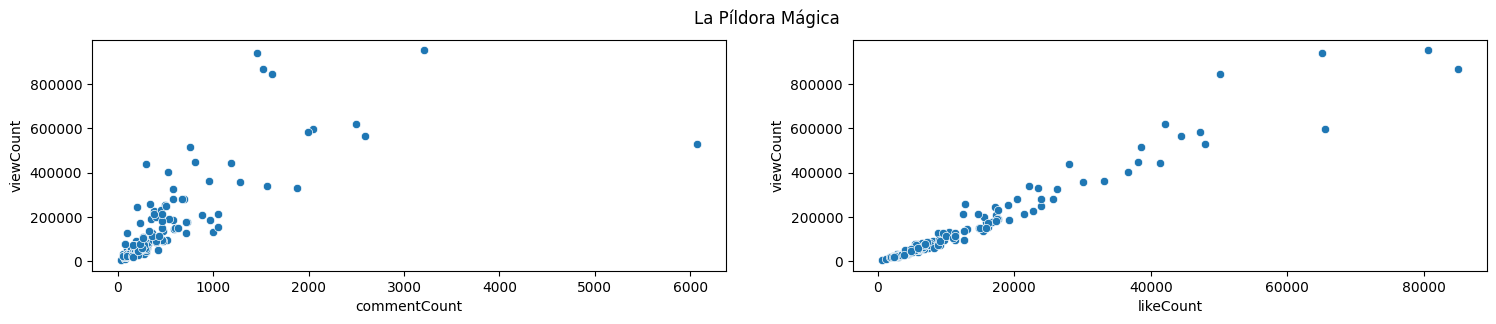

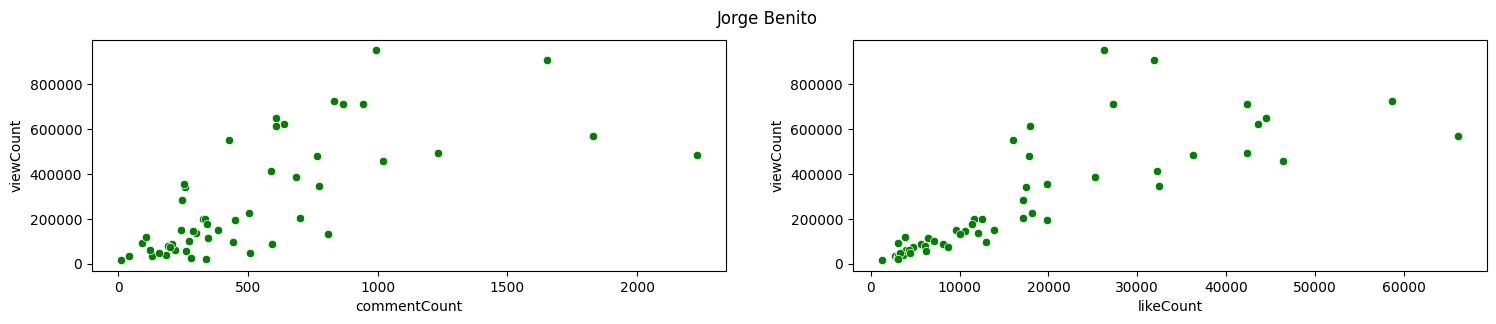

In [24]:


df_video_pildora = df_video_plot[df_video_plot['channelTitle']=='La Píldora Mágica']
df_video_jorgebenito = df_video_plot[df_video_plot['channelTitle']=='Jorge Benito']


fig, ax = plt.subplots(1,2)
sns.scatterplot(data = df_video_pildora, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = df_video_pildora, x = "likeCount", y = "viewCount", ax=ax[1])
fig.suptitle('La Píldora Mágica')

fig, ax = plt.subplots(1,2)
sns.scatterplot(data = df_video_jorgebenito, x = "commentCount", y = "viewCount", ax=ax[0], color='green')
sns.scatterplot(data = df_video_jorgebenito, x = "likeCount", y = "viewCount", ax=ax[1], color='green')
fig.suptitle('Jorge Benito')

Text(0.5, 0.98, 'Jorge Benito')

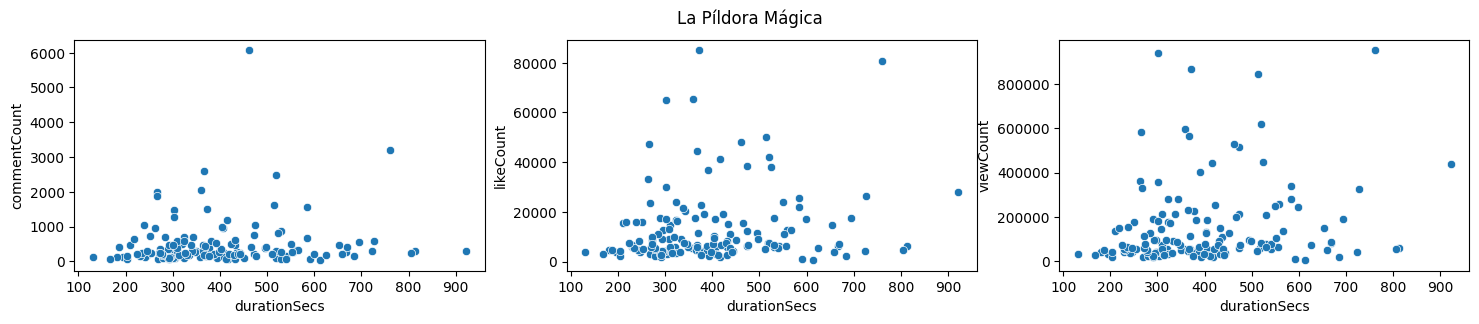

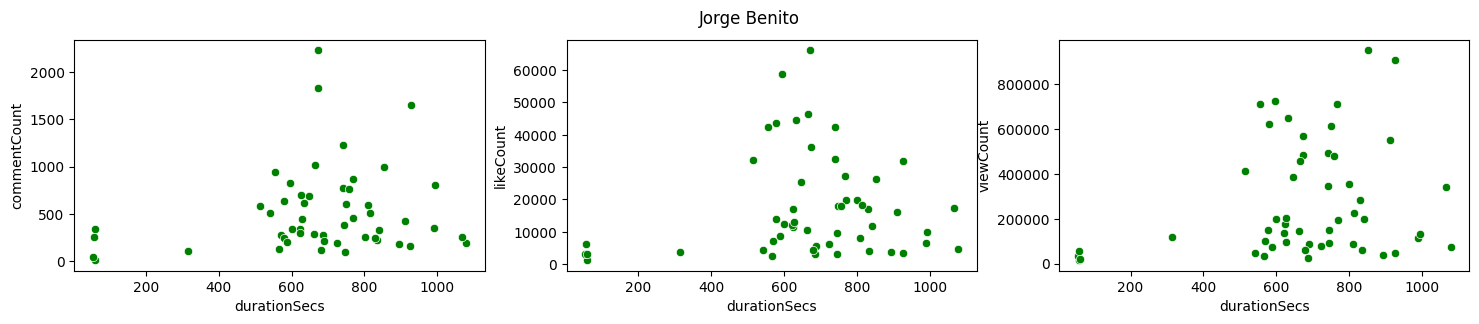

In [25]:
plt.rcParams['figure.figsize'] = (18, 3)
fig, ax = plt.subplots(1,3)
sns.scatterplot(data = df_video_pildora, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = df_video_pildora, x = "durationSecs", y = "likeCount", ax=ax[1])
sns.scatterplot(data = df_video_pildora, x = "durationSecs", y = "viewCount", ax=ax[2])
fig.suptitle('La Píldora Mágica')

fig, ax = plt.subplots(1,3)
sns.scatterplot(data = df_video_jorgebenito, x = "durationSecs", y = "commentCount", ax=ax[0], color='green')
sns.scatterplot(data = df_video_jorgebenito, x = "durationSecs", y = "likeCount", ax=ax[1], color='green')
sns.scatterplot(data = df_video_jorgebenito, x = "durationSecs", y = "viewCount", ax=ax[2], color='green')
fig.suptitle('Jorge Benito')

Text(0.5, 0.98, 'Jorge Benito')

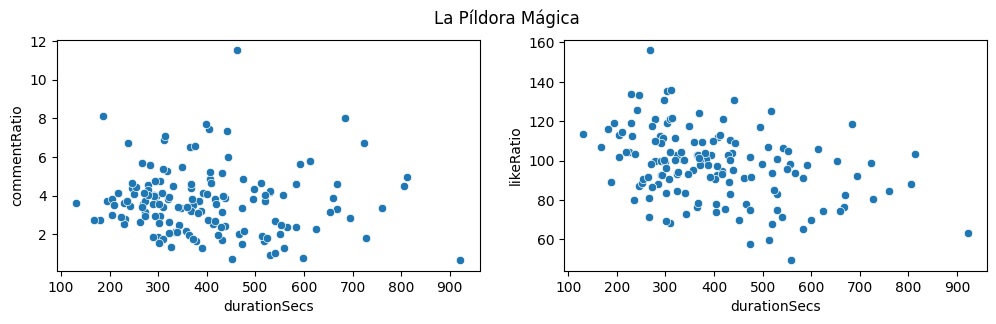

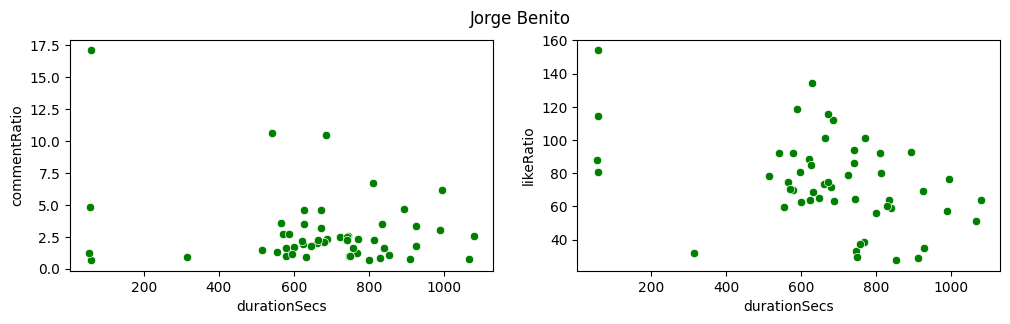

In [26]:
plt.rcParams['figure.figsize'] = (12, 3)
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = df_video_pildora, x = "durationSecs", y = "commentRatio", ax=ax[0])
sns.scatterplot(data = df_video_pildora, x = "durationSecs", y = "likeRatio", ax=ax[1])
fig.suptitle('La Píldora Mágica')

fig, ax = plt.subplots(1,2)
sns.scatterplot(data = df_video_jorgebenito, x = "durationSecs", y = "commentRatio", ax=ax[0], color='green')
sns.scatterplot(data = df_video_jorgebenito, x = "durationSecs", y = "likeRatio", ax=ax[1], color='green')
fig.suptitle('Jorge Benito')


Text(0.5, 0.98, 'Jorge Benito')

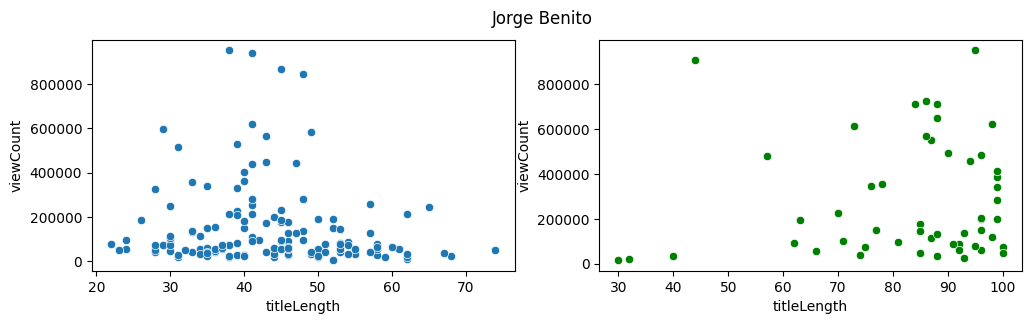

In [27]:
plt.rcParams['figure.figsize'] = (12, 3)
fig, ax = plt.subplots(1,2)

sns.scatterplot(data = df_video_pildora, x = "titleLength", y = "viewCount", ax=ax[0])
fig.suptitle('La Píldora Mágica')

sns.scatterplot(data = df_video_jorgebenito, x = "titleLength", y = "viewCount", ax=ax[1], color='green')
fig.suptitle('Jorge Benito')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alejmrv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alejmrv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_667/1424411502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_video_pildora['title_no_stopwords'] = df_video_pildora['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])


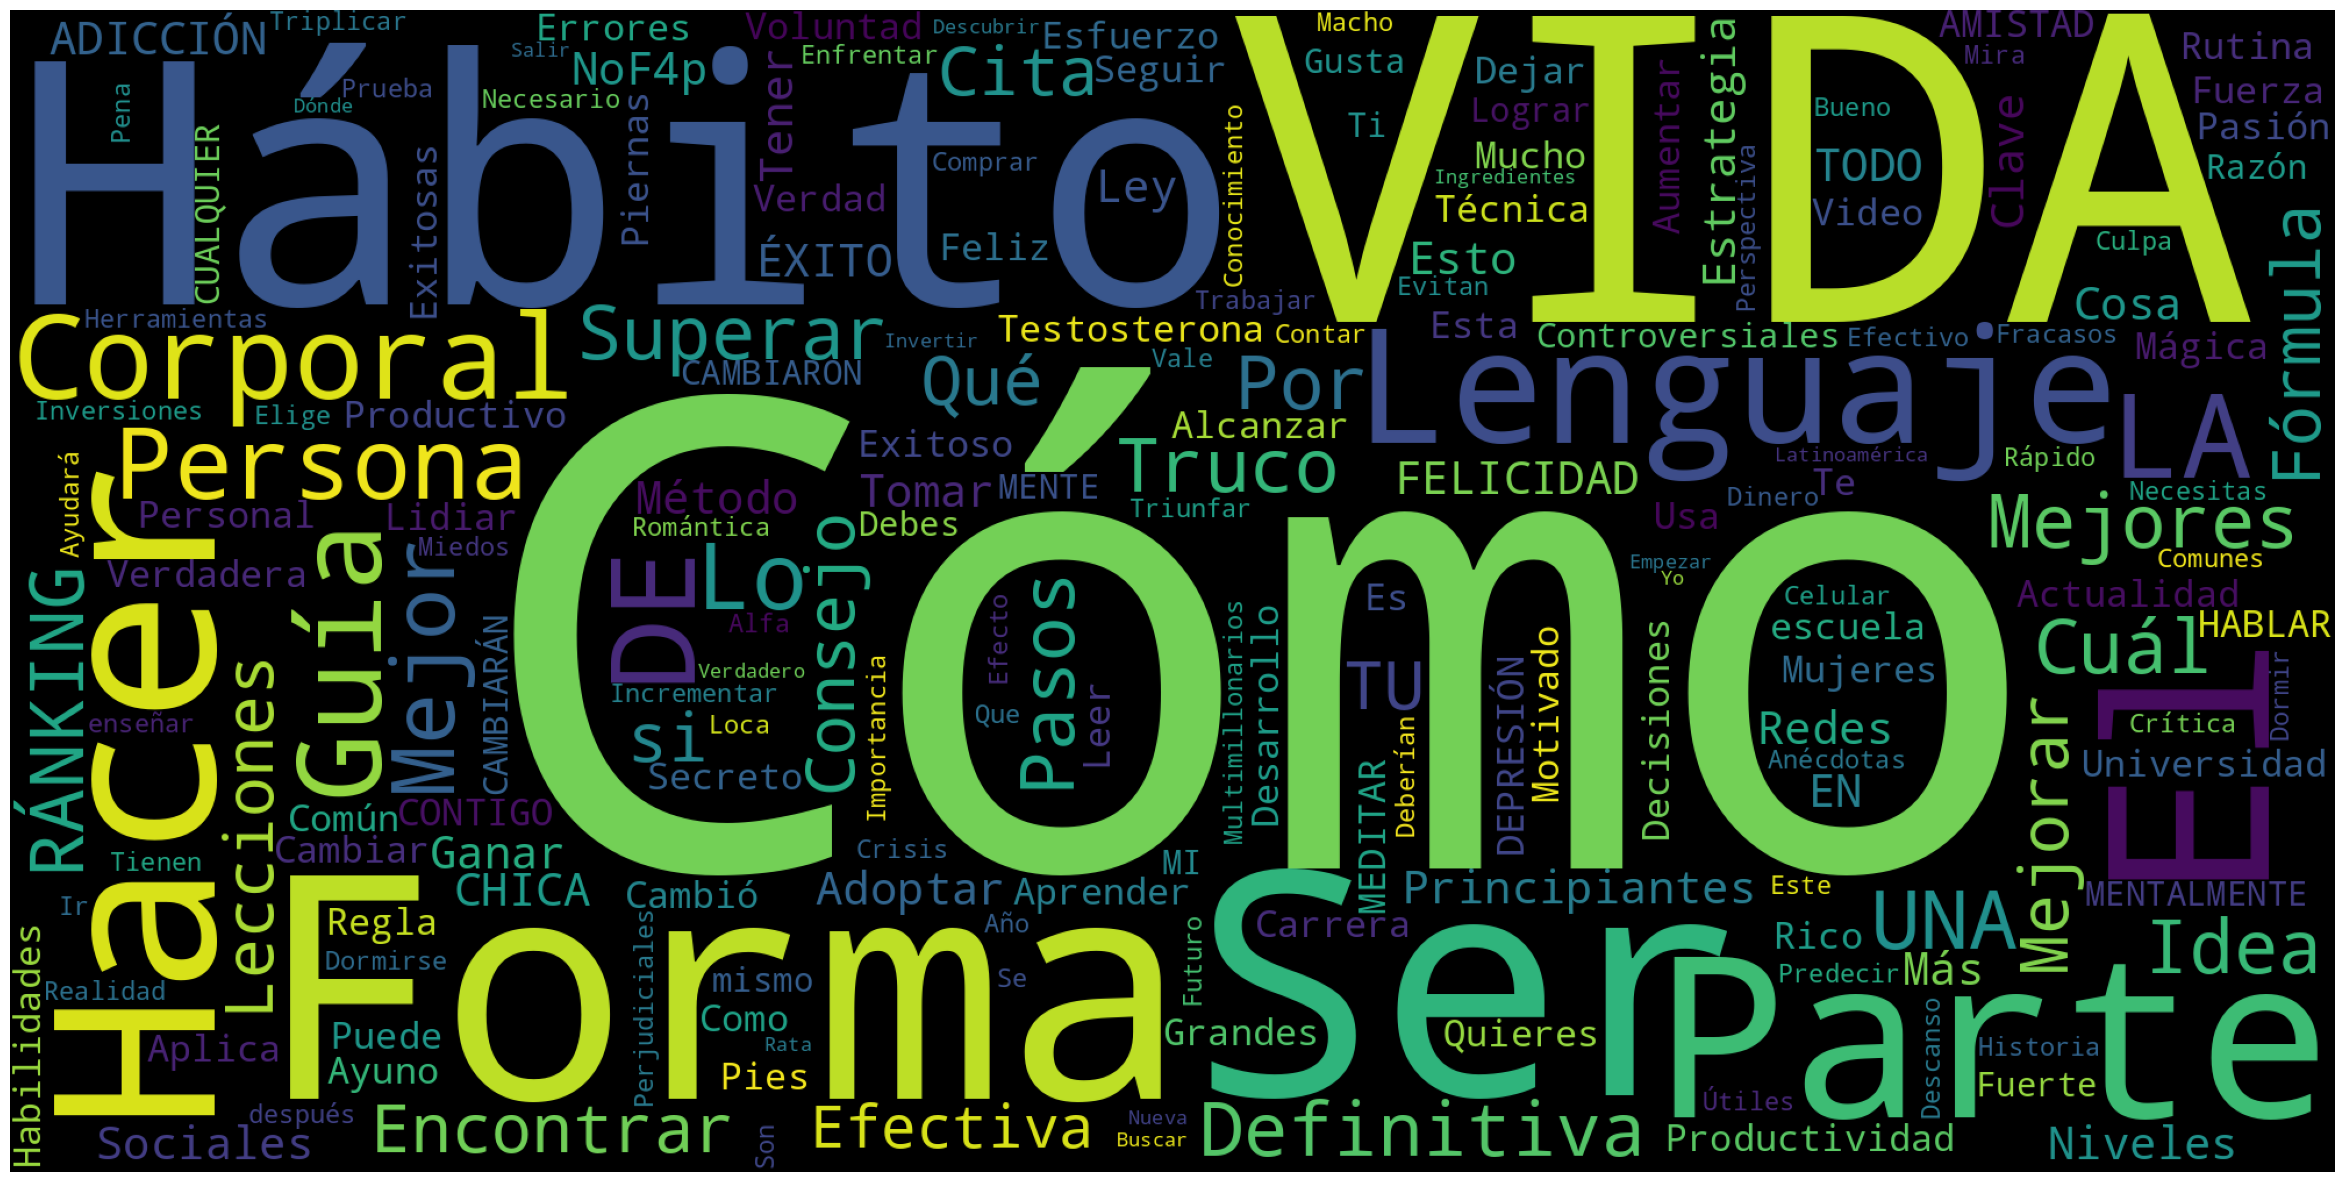

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

stop_words = set(stopwords.words('spanish'))
extra_stop_spanish_words = ['La', 'Mi', 'En']

stop_words.update(extra_stop_spanish_words)

df_video_pildora['title_no_stopwords'] = df_video_pildora['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df_video_pildora['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

/tmp/ipykernel_667/306094779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_video_jorgebenito['title_no_stopwords'] = df_video_jorgebenito['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])


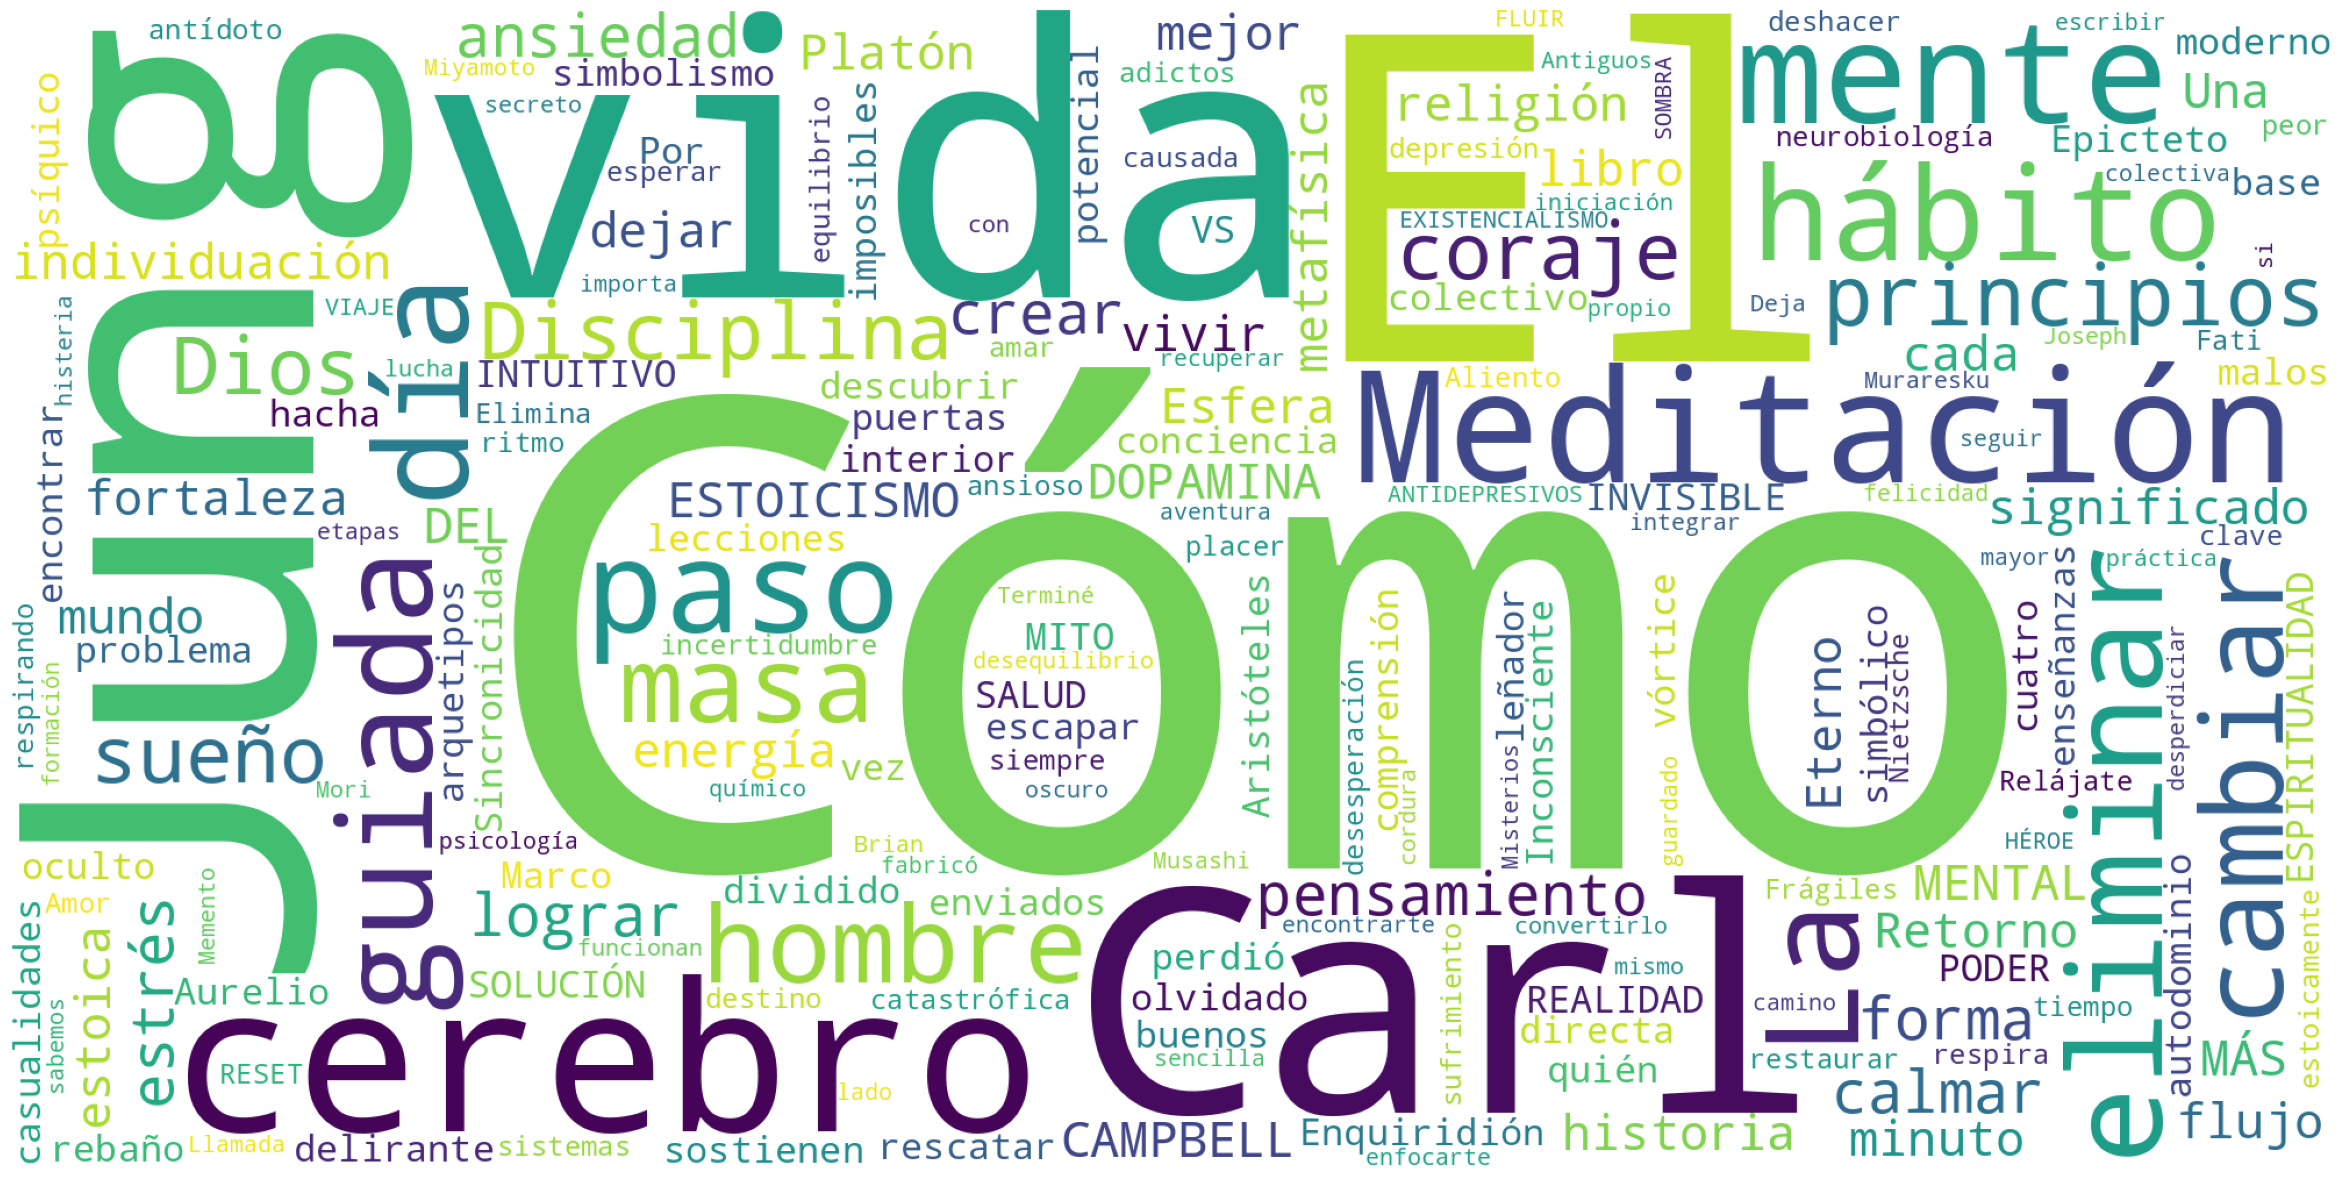

In [31]:
stop_words = set(stopwords.words('spanish'))
extra_stop_spanish_words = ['La', 'Mi', 'En', 'Jorge', 'Benito', 'Los']

stop_words.update(extra_stop_spanish_words)

df_video_jorgebenito['title_no_stopwords'] = df_video_jorgebenito['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df_video_jorgebenito['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)